In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import glob
import scipy
import re
import random
import time
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from scipy.stats import ttest_ind
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold


from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.3f}".format

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_4_exports'
data_folder = '../all_data/Figure_4_data'

# Train neural networks on all active learning and screening reactions

## Uses the same set up as the neural networks used for Figure 3

### Read in dataset

In [6]:
data = pd.read_pickle('../all_data/General_data/screen_active_data.pkl')
data

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,SecYE,K,WCE,PEG,pmol,rxn_id,label
0,eCM313,1.000,1.000,H12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.918,0.000,screen
1,eCM313,1.000,1.000,K12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.311,0.000,screen
2,eCM313,1.000,1.000,M5,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,2.644,0.000,screen
3,eCM313,2.000,4.000,J2,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.546,0.000,screen
4,eCM313,2.000,4.000,N22,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.527,0.000,screen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33542,eCM313,2.000,3.000,A1,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.149,3966.000,screen
33543,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3862.000,screen
33544,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3966.000,screen
33545,eCM313,2.000,4.000,G6,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,2.024,3862.000,screen


In [7]:
sub_df = []

for rxn_id,rxn_df in data.groupby('rxn_id'):
    lipo = rxn_df[rxn_df['Liposome_conc'] != 0].copy()
    nolipo = rxn_df[rxn_df['Liposome_conc'] == 0].copy()
    nolipo_mean = np.mean(nolipo['pmol'])
    if len(nolipo) == 0:
        print(rxn_id)
        continue
    lipo['pmol_sub'] = lipo['pmol'] - nolipo_mean
    nolipo['pmol_sub'] = nolipo['pmol'] - nolipo_mean
    
    sub_df.append(lipo)
    sub_df.append(nolipo)
    
sub_df = pd.concat(sub_df)
sub_df

,experiment_id,day,plate,well_name,Supp,DNA_name,DNA_conc,Liposome_name,Liposome_conc,Mg,SecYE,K,WCE,PEG,pmol,rxn_id,label,pmol_sub
0,eCM313,1.000,1.000,H12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.918,0.000,screen,2.688
1,eCM313,1.000,1.000,K12,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,4.311,0.000,screen,2.081
2,eCM313,1.000,1.000,M5,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,2.644,0.000,screen,0.414
3,eCM313,2.000,4.000,J2,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.546,0.000,screen,5.316
4,eCM313,2.000,4.000,N22,S22,AqpZ,5.000,DMPC,3,8.000,0.000,85,BL62,2.000,7.527,0.000,screen,5.297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33538,eCM313,1.000,2.000,C22,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.915,3966.000,screen,0.238
33540,eCM313,1.000,2.000,N11,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.529,3966.000,screen,-0.148
33542,eCM313,2.000,3.000,A1,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.149,3966.000,screen,-0.529
33544,eCM313,2.000,4.000,B2,S22,Vol,5.000,no_lipo,0,20.000,1.250,135,BL62,2.000,1.265,3966.000,screen,-0.413


### Prepare data for training

In [8]:
training_data = sub_df.copy()
training_data = training_data[training_data['Liposome_name'] != 'no_lipo'].copy()

lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}

training_data['lipid'] = training_data['Liposome_name'].apply(lambda x: lipo_dict[x])
training_data = training_data[['rxn_id','DNA_name','lipid','Mg','SecYE','K','PEG','pmol']].copy()
training_data

,rxn_id,DNA_name,lipid,Mg,SecYE,K,PEG,pmol
0,0.000,AqpZ,14,8.000,0.000,85,2.000,4.918
1,0.000,AqpZ,14,8.000,0.000,85,2.000,4.311
2,0.000,AqpZ,14,8.000,0.000,85,2.000,2.644
3,0.000,AqpZ,14,8.000,0.000,85,2.000,7.546
4,0.000,AqpZ,14,8.000,0.000,85,2.000,7.527
...,...,...,...,...,...,...,...,...
15746,3966.000,Vol,18,20.000,1.250,135,2.000,1.240
15747,3966.000,Vol,18,20.000,1.250,135,2.000,1.230
15748,3966.000,Vol,18,20.000,1.250,135,2.000,1.726
15749,3966.000,Vol,18,20.000,1.250,135,2.000,1.145


In [9]:
prot_feat = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')
prot_feat

,uniprot,DNA_name,Organism,Length,tm_count,Mass
0,P60844,AqpZ,E. coli,231,6,23.703
1,F4HWB6,Aux,A. thaliana,472,10,51.877
2,P07550,B2AR,H. sapiens,413,7,46.459
3,P13945,B3AR,H. sapiens,408,7,43.519
4,Q9LTG0,Beta,A. thaliana,303,4,33.777
...,...,...,...,...,...,...
26,P0AGA2,SecYE-G,E. coli,443,12,48.512
27,Q5JW98,Vol,H. sapiens,314,4,35.060
28,Q8RXN3,PPT1,A. thaliana,408,8,44.200
29,Q96247,AuxT1,A. thaliana,485,11,54.100


In [10]:
def add_one_hot(df,col_name):
    temp = df[[col_name]]

    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoder.fit(temp)

    encoded = one_hot_encoder.transform(temp)
    encoded = pd.DataFrame(data=encoded, columns=[col_name+'-'+c for c in one_hot_encoder.categories_])
    df = df.join(encoded)
    targets = list([col_name+'-'+c for c in one_hot_encoder.categories_])[0]
    original = [(t,) for t in targets]
    df = df.rename(columns=dict(zip(original,targets)))
    return df


dna_encoded = add_one_hot(prot_feat[['DNA_name']],'DNA_name')

dna_encoded

,DNA_name,DNA_name-AqpZ,DNA_name-Aux,DNA_name-AuxT1,DNA_name-B2AR,DNA_name-B3AR,DNA_name-Beta,DNA_name-CD47,DNA_name-CD63,DNA_name-CD81,...,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol
0,AqpZ,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,Aux,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,B2AR,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,B3AR,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Beta,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,SecYE-G,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
27,Vol,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
28,PPT1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
29,AuxT1,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [11]:
all_features = training_data.set_index('DNA_name').join(dna_encoded.set_index('DNA_name')).reset_index()
all_features

,DNA_name,rxn_id,lipid,Mg,SecYE,K,PEG,pmol,DNA_name-AqpZ,DNA_name-Aux,...,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol
0,AqpZ,0.000,14,8.000,0.000,85,2.000,4.918,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,AqpZ,0.000,14,8.000,0.000,85,2.000,4.311,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,AqpZ,0.000,14,8.000,0.000,85,2.000,2.644,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,AqpZ,0.000,14,8.000,0.000,85,2.000,7.546,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,AqpZ,0.000,14,8.000,0.000,85,2.000,7.527,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,Vol,3966.000,18,20.000,1.250,135,2.000,1.240,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
5502,Vol,3966.000,18,20.000,1.250,135,2.000,1.230,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
5503,Vol,3966.000,18,20.000,1.250,135,2.000,1.726,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
5504,Vol,3966.000,18,20.000,1.250,135,2.000,1.145,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


### Min-Max scaling

In [12]:
data_bounded = all_features[['Mg', 'SecYE', 'K', 'PEG','lipid']]
X_bounded = np.array(data_bounded)
scalerX = MinMaxScaler()
X_bounded = scalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = all_features['rxn_id']
data_bounded = data_bounded.drop_duplicates().set_index('rxn_id')
data_bounded

,Mg,SecYE,K,PEG,lipid
rxn_id,,,,,
0.000,0.000,0.000,0.000,1.000,0.000
1.000,0.000,0.000,0.000,0.000,0.000
2.000,0.000,0.000,0.000,1.000,0.000
3.000,0.000,0.000,0.500,1.000,0.000
4.000,0.000,0.000,0.500,0.000,0.000
...,...,...,...,...,...
3953.000,1.000,0.000,0.500,1.000,1.000
3954.000,1.000,0.000,1.000,0.000,1.000
3964.000,1.000,0.500,1.000,0.000,1.000


### Standard Scaling

In [13]:
y_col = 'pmol'

transformed = []
scaler_dict = {}

for dna, dna_df in all_features.groupby('DNA_name'):
    temp = dna_df.copy()
    y_scaled = np.array(dna_df[[y_col]])
    scalerY = StandardScaler()
    y_scaled = scalerY.fit_transform(y_scaled)
    temp['label'] = y_scaled
    transformed.append(temp)
    scaler_dict.update({dna:scalerY})
transformed = pd.concat(transformed)
transformed = transformed[['rxn_id','label']].set_index('rxn_id')
transformed

,label
rxn_id,
0.000,-0.570
0.000,-0.656
0.000,-0.891
0.000,-0.201
0.000,-0.203
...,...
3966.000,-0.656
3966.000,-0.665
3966.000,-0.194


In [14]:
encoded_cols = [c for c in all_features.columns if '-' in c]
encoded_cols = all_features[encoded_cols+['rxn_id','DNA_name']].drop_duplicates().set_index('rxn_id')
encoded_cols

,DNA_name-AqpZ,DNA_name-Aux,DNA_name-AuxT1,DNA_name-B2AR,DNA_name-B3AR,DNA_name-Beta,DNA_name-CD47,DNA_name-CD63,DNA_name-CD81,DNA_name-CD9,...,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol,DNA_name
rxn_id,,,,,,,,,,,,,,,,,,,,,
0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
3.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
4.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
3954.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
3964.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol


In [15]:
norm_data = transformed.join(data_bounded).join(encoded_cols).reset_index()
norm_data

,rxn_id,label,Mg,SecYE,K,PEG,lipid,DNA_name-AqpZ,DNA_name-Aux,DNA_name-AuxT1,...,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol,DNA_name
0,0.000,-0.570,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
1,0.000,-0.656,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
2,0.000,-0.891,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
3,0.000,-0.201,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
4,0.000,-0.203,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AqpZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,3966.000,-0.656,1.000,1.000,0.500,1.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
5502,3966.000,-0.665,1.000,1.000,0.500,1.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
5503,3966.000,-0.194,1.000,1.000,0.500,1.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol
5504,3966.000,-0.745,1.000,1.000,0.500,1.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,Vol


### Design feature sets for ensembles

In [16]:
rxn_features = ['Mg','SecYE','K','PEG','lipid']
dna_features = [c for c in norm_data.columns if 'DNA_name-' in c]


In [17]:
col_dict = {
    'no_prot_features':rxn_features,
    'dna_encoded':rxn_features+dna_features,
}

In [18]:
def make_model(learning_rate=1e-3,nodes=[256,128,64,32,16]):
    temp = [tf.keras.layers.Dense(n, activation='relu') for n in nodes] + [tf.keras.layers.Dense(1, activation="linear")]
    model = tf.keras.Sequential([*temp])
    
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

def prep_data(train,test):
    to_drop = 'rxn_id'
    train = train.drop(columns=to_drop)
    test = test.drop(columns=to_drop)
    
    target = 'label'
    cols = [col for col in train.columns.values if col != target]

    X_train = np.array(train[cols])
    y_train = train[target].values.reshape(-1, 1)

    X_test = np.array(test[cols])
    y_test = test[target].values.reshape(-1, 1)
    
    return train,test,X_train,X_test,y_train,y_test

### Generate metadata to define the model training parameters

In [19]:

layer_arr = []
num_layers = [4,5,6]

nodes = [2**i for i in range(4,12)][::-1]
start = 'low'
for num in num_layers:
    if start == 'high':
        layers = [nodes[i] for i in range(num)]
    elif start == 'low':
        layers = [nodes[len(nodes)-i-1] for i in range(num)][::-1]
    layer_arr.append(layers)

learning_rates = [1e-3]
batch_sizes = [10,50,200]

ensemble = ['dna_encoded']


folds = range(5)

combinations = list(itertools.product(ensemble,folds,batch_sizes,learning_rates,layer_arr))
combinations = pd.DataFrame(combinations,columns=['ensemble','fold','batch','learning_rate','nodes']).reset_index().rename(columns={'index':'model_id'}).set_index('model_id')
combinations = combinations.reset_index()
combinations['cols'] = combinations['ensemble'].apply(lambda x: col_dict[x])
combinations


def partition (list_in, n,random_seed=0):
    random.Random(random_seed).shuffle(list_in)
    return [[i,list_in[i::n]] for i in range(n)]

def get_train_ids(test_ids,available_ids):
    return [i for i in available_ids if i not in test_ids]

subset_ids = norm_data['rxn_id'].drop_duplicates().tolist()
test_ids = partition(subset_ids,len(folds))
test_ids = pd.DataFrame(test_ids,columns=['fold','test_ids'])
test_ids['train_ids'] = test_ids['test_ids'].apply(get_train_ids,available_ids=subset_ids)
    
combinations = combinations.set_index('fold').join(test_ids.set_index('fold')).reset_index()

combinations

,fold,model_id,ensemble,batch,learning_rate,nodes,cols,test_ids,train_ids
0,0,0,dna_encoded,10,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
1,0,1,dna_encoded,10,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
2,0,2,dna_encoded,10,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
3,0,3,dna_encoded,50,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
4,0,4,dna_encoded,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
...,...,...,...,...,...,...,...,...,...
40,4,40,dna_encoded,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
41,4,41,dna_encoded,50,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
42,4,42,dna_encoded,200,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
43,4,43,dna_encoded,200,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."


### Train the models

In [18]:
time_start = time.strftime("%Y-%m-%d_%H-%M", time.gmtime())
dir_name = f'Rxn_cluster_sub-regression-models {time_start}'
dir_path = f'./{dir_name}'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
else:
    print('Directory already exists - Overwriting data')
    
combinations.to_pickle(f'{dir_path}/model_id_info.pkl')

    
EPOCHS = 100

for i,row in combinations.iterrows():
    if os.path.exists(f'{dir_path}/model-{row.model_id}.keras'):
        print(f'{dir_path}/model-{row.model_id} already trained')
        continue
    print(f'\n\n{row.model_id}: {round(i/len(combinations)*100,1)}%, ensemble: {row.ensemble}, nodes: {row.nodes}')
        
    t = norm_data[row.cols + ['rxn_id','label']]
    train = t[t['rxn_id'].isin(row['train_ids'])]
    test = t[t['rxn_id'].isin(row['test_ids'])]
    
    train,test,X_train,X_test,y_train,y_test = prep_data(train,test)
    model = make_model(learning_rate=row['learning_rate'],nodes=row['nodes'])

    history = model.fit(
            X_train,
            y_train,
            batch_size=int(row['batch']),
            epochs=EPOCHS,
            validation_data=(X_test, y_test))

    model.save(f'{dir_path}/model-{row.model_id}.keras')
        
    print('current time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))

print('Start time: ',time_start)
print('End time: ',time.strftime("%Y-%m-%d_%H-%M", time.gmtime()))



0: 0.0%, ensemble: dna_encoded, nodes: [128, 64, 32, 16]
Epoch 1/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6992 - val_loss: 0.6750
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.6132 - val_loss: 0.6260
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.5329 - val_loss: 0.6103
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.5312 - val_loss: 0.5962
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.4997 - val_loss: 0.6123
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.4844 - val_loss: 0.6082
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.4643 - val_loss: 0.5987
Epoch 8/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.4468 - val_loss: 0.6062
Epoch 9/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.4525 - val_loss: 0.5996
Epoch 10/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.4522 - val_loss: 0.5988
Epoch 11/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/s

### Read in and evaluate the model performances

In [43]:
dir_path = data_folder+'/Rxn_cluster_sub-regression-models'
paths = [p for p in glob.glob(f'./{dir_path}/*') if '.pkl' not in p]
paths
model_dict = {}
for path in paths:
    print(path)
    model_num = int(path.split('\\')[-1].split('-')[-1].split('.')[0])
    current_model = keras.models.load_model(path)
    model_dict.update({model_num:current_model})
    
model_data = pd.read_pickle(glob.glob(f'{dir_path}/*.pkl')[0])
model_data

./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-0.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-1.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-10.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-11.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-12.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-13.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-14.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-15.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-16.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-17.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-18.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-19.keras
./../all_data/Figure_4_data/Rxn_cluster_sub-regression-models\model-2.keras
./

,fold,model_id,ensemble,batch,learning_rate,nodes,cols,test_ids,train_ids
0,0,0,dna_encoded,10,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
1,0,1,dna_encoded,10,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
2,0,2,dna_encoded,10,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
3,0,3,dna_encoded,50,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
4,0,4,dna_encoded,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1538.0, 23.0, 2947.0, 1002.0, 1161.0, 2930.0,...","[2984.0, 1911.0, 3399.0, 2755.0, 3091.0, 2522...."
...,...,...,...,...,...,...,...,...,...
40,4,40,dna_encoded,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
41,4,41,dna_encoded,50,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
42,4,42,dna_encoded,200,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."
43,4,43,dna_encoded,200,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2755.0, 3418.0, 3082.0, 542.0, 2044.0, 2876.0...","[1538.0, 2984.0, 1911.0, 3399.0, 23.0, 3091.0,..."


In [20]:
test_preds = []

for i,row in model_data.iterrows():
    temp = all_features[all_features['rxn_id'].isin(list(row['test_ids']))].copy()
    temp_norm = norm_data[norm_data['rxn_id'].isin(row['test_ids'])].copy()

    preds = model_dict[row['model_id']].predict(temp_norm[row['cols']])
    temp['pred'] = preds
    temp['model_id'] = row['model_id']
    temp['ensemble'] = row['ensemble']
    test_preds.append(temp)
    
test_preds = pd.concat(test_preds).reset_index(drop=True)

test_converted = []

for dna,dna_df in test_preds.groupby('DNA_name'):
    temp = dna_df.copy()
    temp['pmol_sub_pred'] = scaler_dict[dna].inverse_transform(np.array(temp[['pred']]))
    temp['label'] = scaler_dict[dna].transform(np.array(temp[['pmol']]))
    test_converted.append(temp)
    
test_converted = pd.concat(test_converted).reset_index(drop=True)
test_converted


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━

,DNA_name,rxn_id,lipid,Mg,SecYE,K,PEG,pmol,DNA_name-AqpZ,DNA_name-Aux,...,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol,pred,model_id,ensemble,pmol_sub_pred,label
0,AqpZ,5.000,14,8.000,0.000,135,1.000,17.316,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.130,0,dna_encoded,9.896,1.175
1,AqpZ,5.000,14,8.000,0.000,135,1.000,16.498,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.130,0,dna_encoded,9.896,1.059
2,AqpZ,5.000,14,8.000,0.000,135,1.000,18.653,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.130,0,dna_encoded,9.896,1.363
3,AqpZ,5.000,14,8.000,0.000,135,1.000,16.215,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.130,0,dna_encoded,9.896,1.020
4,AqpZ,8.000,14,8.000,0.000,185,1.000,17.824,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.173,0,dna_encoded,10.198,1.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49549,Vol,3944.000,18,16.000,1.250,135,2.000,1.427,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,-0.436,44,dna_encoded,1.471,-0.478
49550,Vol,3944.000,18,16.000,1.250,135,2.000,1.837,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,-0.436,44,dna_encoded,1.471,-0.088
49551,Vol,3944.000,18,16.000,1.250,135,2.000,1.319,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,-0.436,44,dna_encoded,1.471,-0.580
49552,Vol,3944.000,18,16.000,1.250,135,2.000,1.183,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,-0.436,44,dna_encoded,1.471,-0.710


In [21]:
test_converted['pmol_sub'] = test_converted['label']
test_converted['pmol_sub_pred'] = test_converted['pred']

In [22]:
pred_df = test_converted.copy()

pred_df = pred_df.set_index(['ensemble','model_id']).join(model_data.set_index(['ensemble','model_id'])).reset_index()
stdevs = pred_df.groupby(['ensemble','rxn_id'])[['pmol_sub_pred']].agg('std')
means = pred_df.groupby(['ensemble','rxn_id'])[['pmol_sub_pred']].agg('mean')
calcs = means.join(stdevs,rsuffix='_stdev',lsuffix='_mean')
calcs['cv'] = abs(calcs['pmol_sub_pred_stdev'] / calcs['pmol_sub_pred_mean'])

calcs['cv'] = calcs['cv'].clip(0,5)

calcs = pred_df.set_index(['ensemble','rxn_id']).join(calcs).reset_index().drop(columns=['test_ids','train_ids','cols','nodes'])
calcs


,ensemble,rxn_id,model_id,DNA_name,lipid,Mg,SecYE,K,PEG,pmol,...,pred,pmol_sub_pred,label,pmol_sub,fold,batch,learning_rate,pmol_sub_pred_mean,pmol_sub_pred_stdev,cv
0,dna_encoded,5.000,0,AqpZ,14,8.000,0.000,135,1.000,17.316,...,0.130,0.130,1.175,1.175,0,10,0.001,0.167,0.149,0.895
1,dna_encoded,5.000,0,AqpZ,14,8.000,0.000,135,1.000,16.498,...,0.130,0.130,1.059,1.059,0,10,0.001,0.167,0.149,0.895
2,dna_encoded,5.000,0,AqpZ,14,8.000,0.000,135,1.000,18.653,...,0.130,0.130,1.363,1.363,0,10,0.001,0.167,0.149,0.895
3,dna_encoded,5.000,0,AqpZ,14,8.000,0.000,135,1.000,16.215,...,0.130,0.130,1.020,1.020,0,10,0.001,0.167,0.149,0.895
4,dna_encoded,8.000,0,AqpZ,14,8.000,0.000,185,1.000,17.824,...,0.173,0.173,1.246,1.246,0,10,0.001,0.274,0.078,0.285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49549,dna_encoded,3944.000,44,Vol,18,16.000,1.250,135,2.000,1.427,...,-0.436,-0.436,-0.478,-0.478,4,200,0.001,-0.530,0.060,0.113
49550,dna_encoded,3944.000,44,Vol,18,16.000,1.250,135,2.000,1.837,...,-0.436,-0.436,-0.088,-0.088,4,200,0.001,-0.530,0.060,0.113
49551,dna_encoded,3944.000,44,Vol,18,16.000,1.250,135,2.000,1.319,...,-0.436,-0.436,-0.580,-0.580,4,200,0.001,-0.530,0.060,0.113
49552,dna_encoded,3944.000,44,Vol,18,16.000,1.250,135,2.000,1.183,...,-0.436,-0.436,-0.710,-0.710,4,200,0.001,-0.530,0.060,0.113


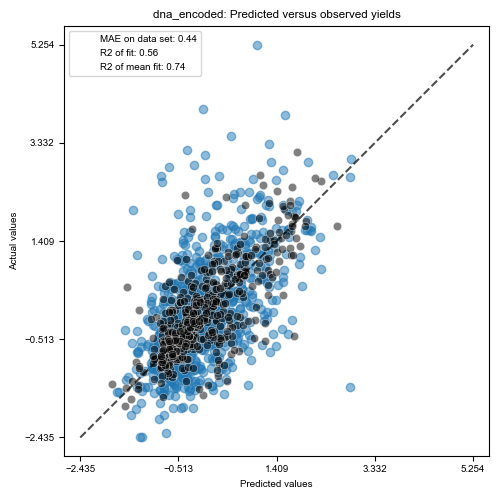

In [23]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

for ensemble,ensemble_df in pred_df.groupby('ensemble'):
    mae_train = median_absolute_error(ensemble_df['pmol_sub'], ensemble_df['pmol_sub_pred'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ensemble_df['pmol_sub'], ensemble_df['pmol_sub_pred'])
    
    t = ensemble_df.groupby(group_cols)[['pmol_sub','pmol_sub_pred']].agg('mean')
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t['pmol_sub'], t['pmol_sub_pred'])
    
    scores = {
        "MAE on data set": f"{mae_train:.2f}",
        "R2 of fit": f"{r_value:.2f}",
        "R2 of mean fit": f"{r_value_mean:.2f}",
    }

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        ensemble_df['pmol_sub'], ensemble_df['pmol_sub_pred'], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    
    sns.scatterplot(data=t.sample(500),x='pmol_sub_pred',y='pmol_sub',color='black',alpha=0.5)
    
    ax.set_title(f"{ensemble}: Predicted versus observed yields")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

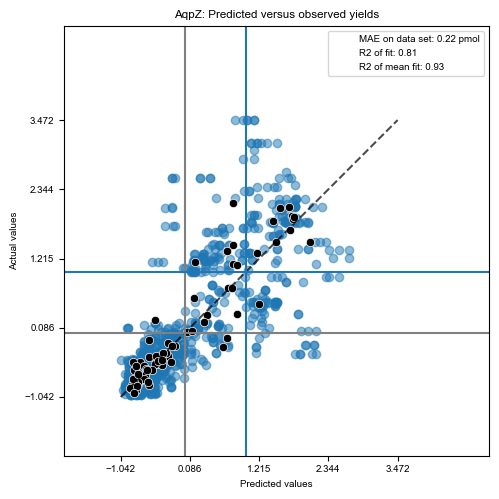

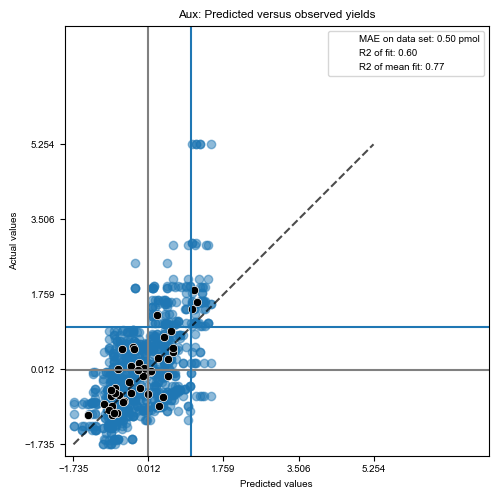

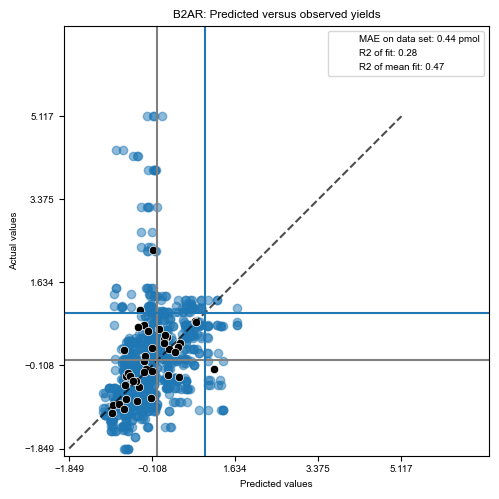

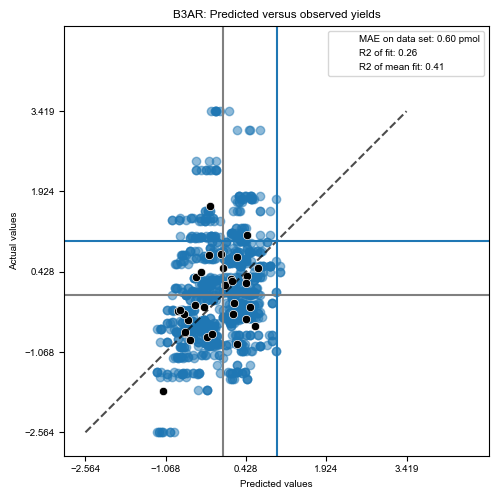

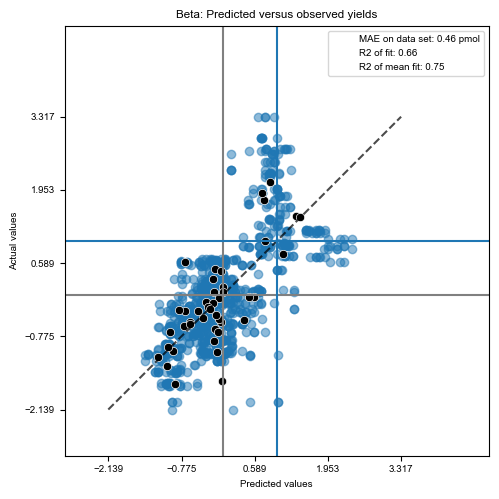

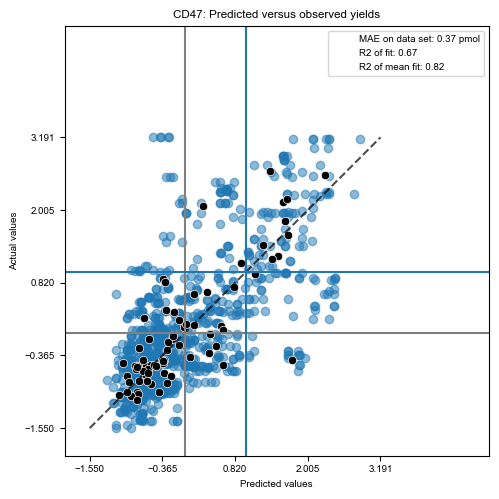

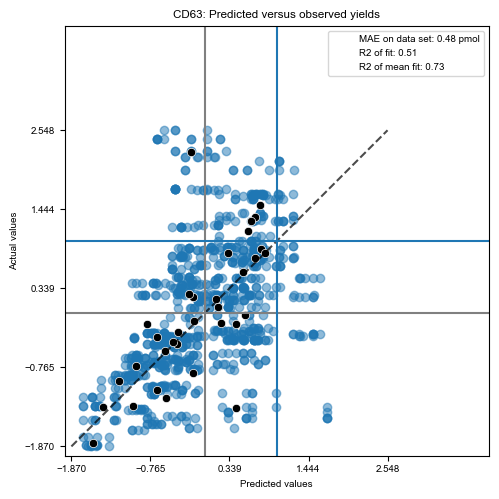

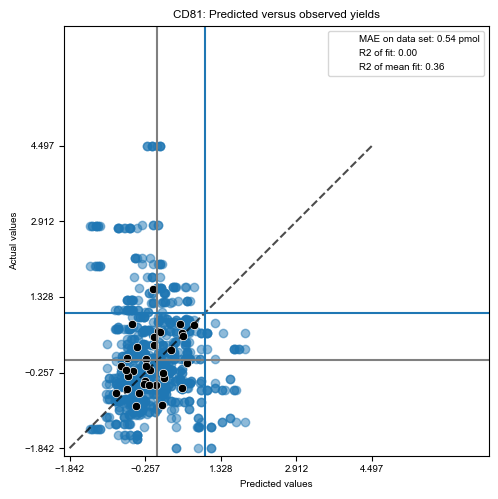

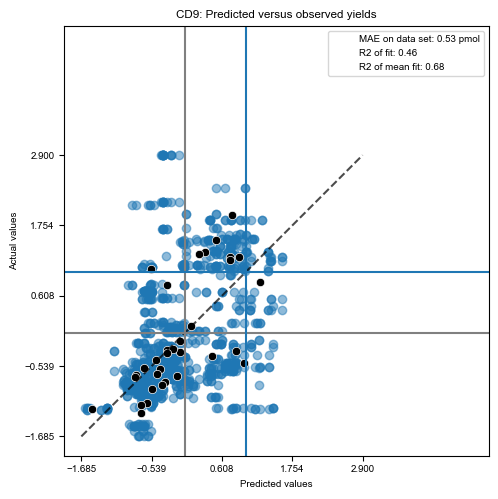

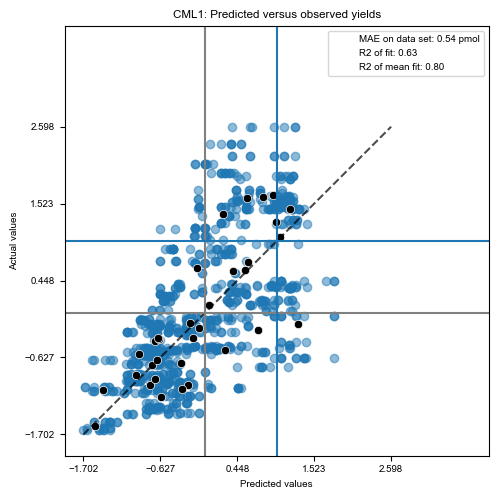

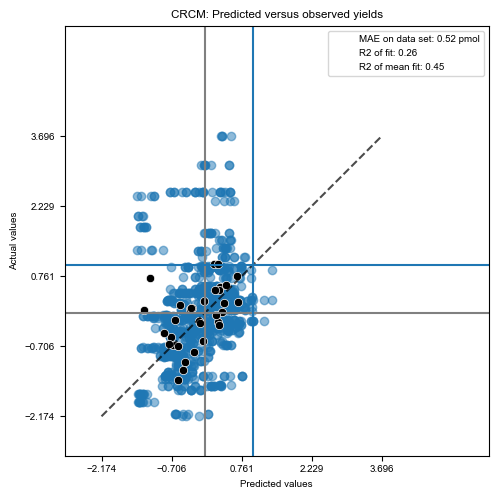

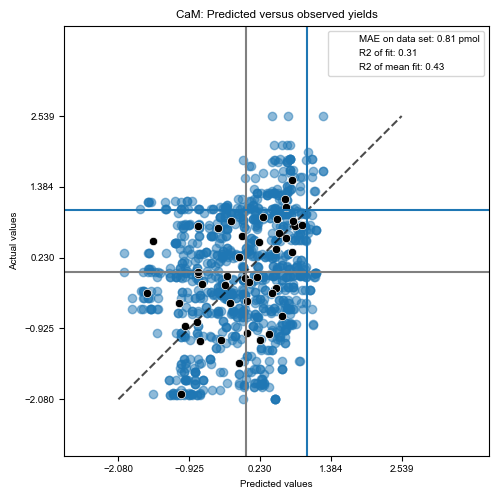

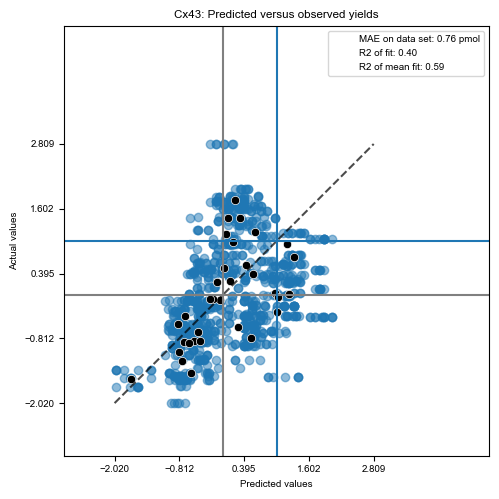

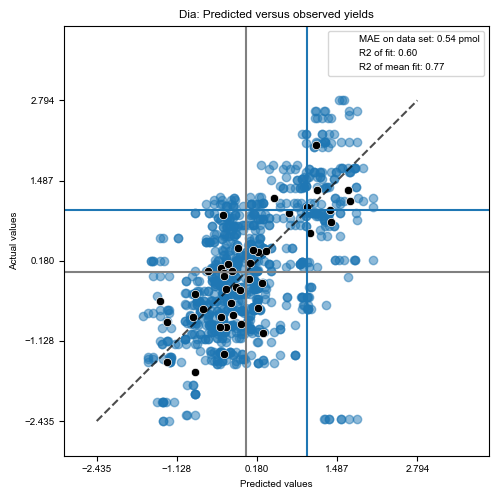

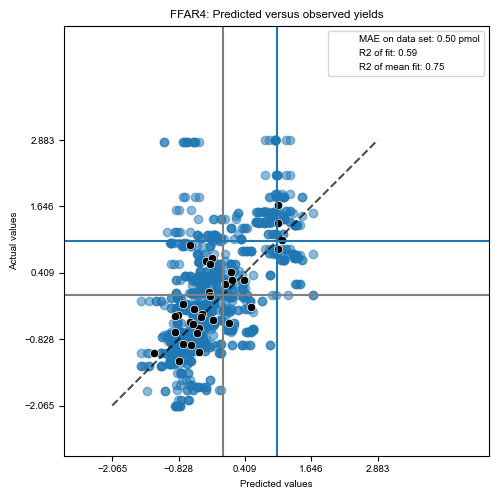

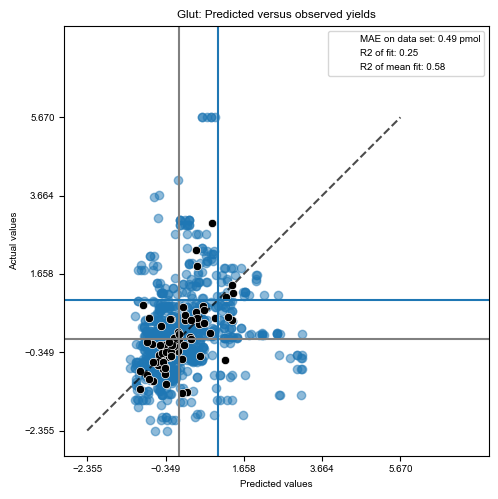

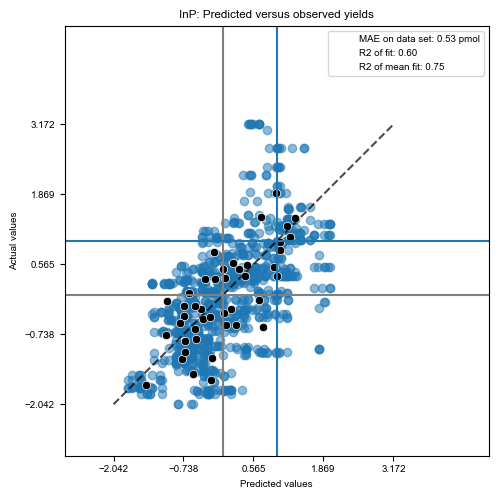

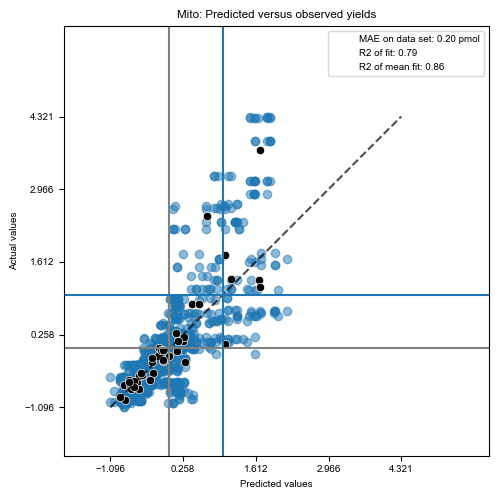

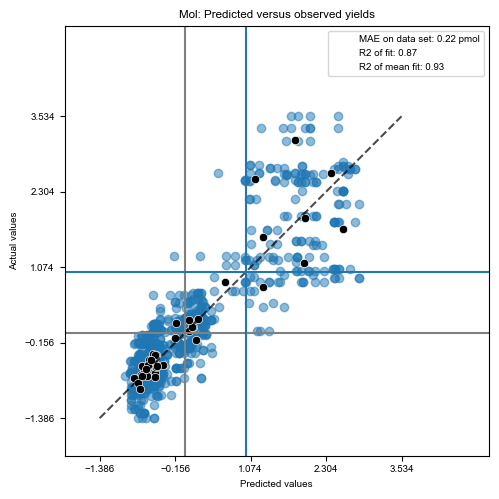

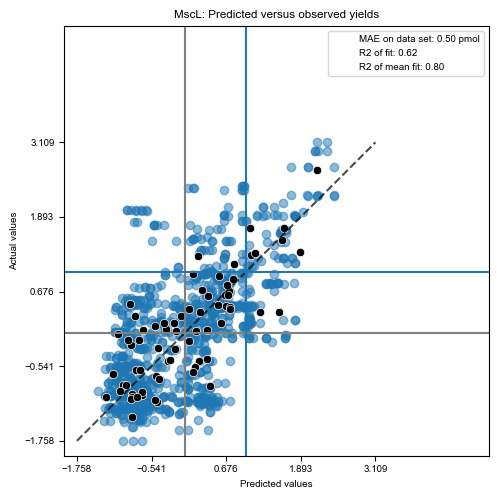

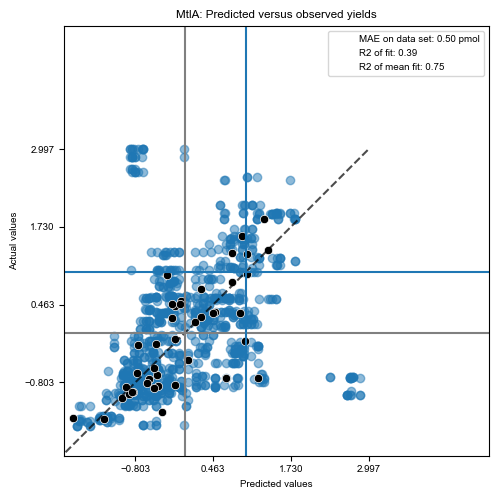

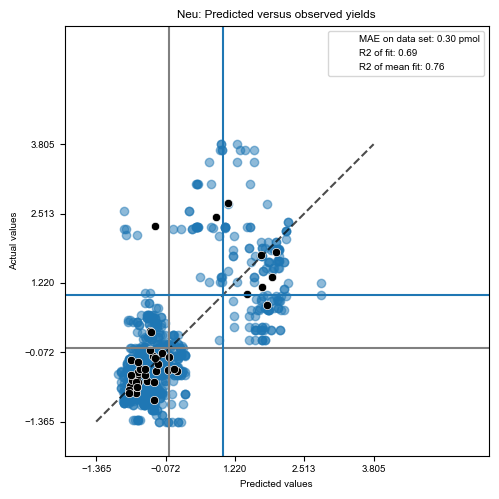

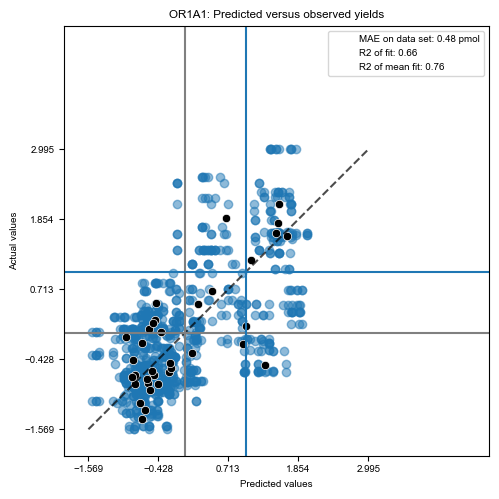

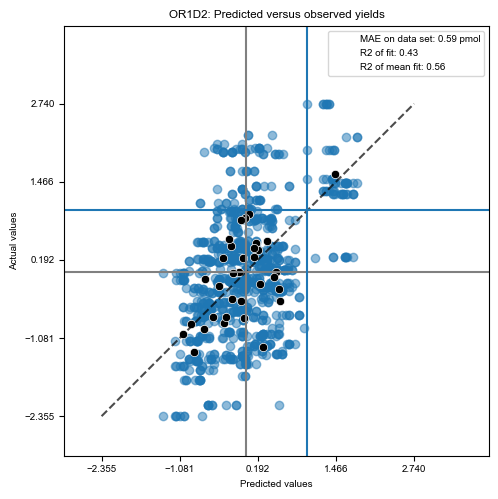

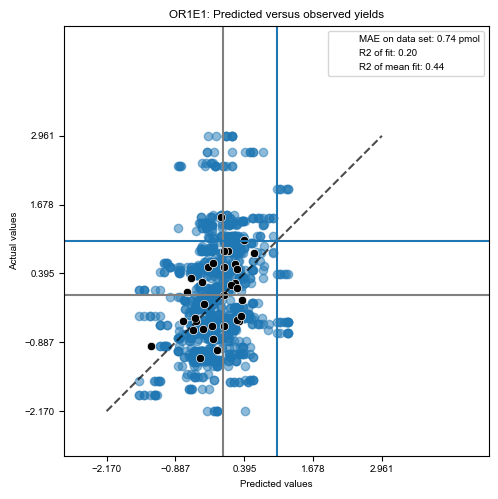

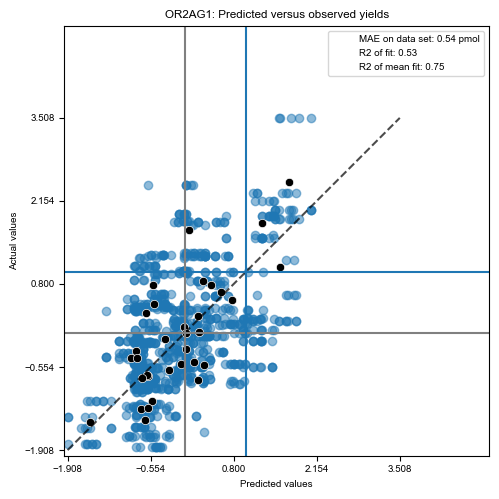

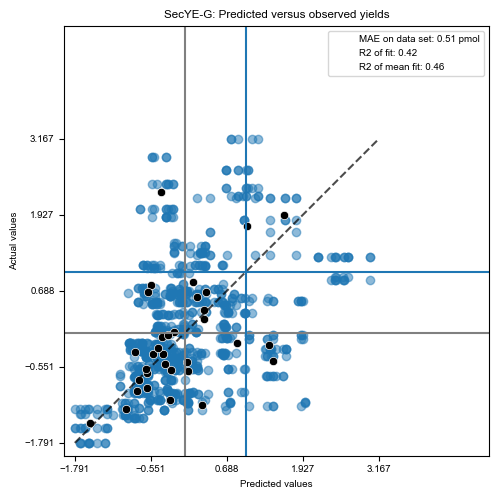

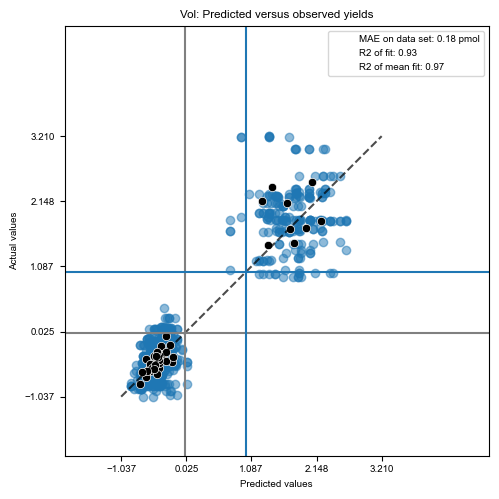

In [24]:
group_cols = ['DNA_name','Mg', 'SecYE', 'K', 'PEG','lipid']

for dna,dna_df in calcs[calcs['ensemble'] == 'dna_encoded'].groupby('DNA_name'):
    mae_train = median_absolute_error(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dna_df['pmol_sub'], dna_df['pmol_sub_pred'])
    
    t = dna_df.groupby(group_cols)[['pmol_sub','pmol_sub_pred']].agg('mean')
    slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = scipy.stats.linregress(t['pmol_sub'], t['pmol_sub_pred'])

    scores = {
        "MAE on data set": f"{mae_train:.2f} pmol",
        "R2 of fit": f"{r_value:.2f}",
        "R2 of mean fit": f"{r_value_mean:.2f}",
    }

    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        dna_df['pmol_sub'], dna_df['pmol_sub_pred'], kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    ax.set_title(f"{dna}: Predicted versus observed yields")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    plt.tight_layout()

    plt.axvline(0,color='grey')
    plt.axhline(0,color='grey')
    upper = round(np.max(dna_df['pmol_sub'])*1.25)+1
    lower = round(np.min(dna_df['pmol_sub'])*0.75)-1

    
    sns.scatterplot(data=t,x='pmol_sub_pred',y='pmol_sub',color='black')
    plt.xlim([lower,upper])
    plt.ylim([lower,upper])
    plt.axvline(1)
    plt.axhline(1)
    
    plt.show()

### Use models to predict on possible reaction conditions

In [25]:
cols = [c for c in encoded_cols.columns if 'DNA_name' in c]
dna_encodings = encoded_cols.reset_index().drop(columns=['rxn_id']).drop_duplicates()[cols].set_index('DNA_name')
dna_encodings

,DNA_name-AqpZ,DNA_name-Aux,DNA_name-AuxT1,DNA_name-B2AR,DNA_name-B3AR,DNA_name-Beta,DNA_name-CD47,DNA_name-CD63,DNA_name-CD81,DNA_name-CD9,...,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol
DNA_name,,,,,,,,,,,,,,,,,,,,,
AqpZ,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Aux,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B2AR,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B3AR,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Beta,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OR1D2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
OR1E1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
OR2AG1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000


In [26]:
combo_df = pd.read_excel('../all_data/General_data/possible_reaction_conditions.xlsx')

# Group the reagent and its concentration into a single id
combo_df['list_combo'] = list(zip(combo_df.group,combo_df.reagent, combo_df.conc))

# Pulls out each reagent within the same group so that they are not combined together
combos = []
for reagent,df in combo_df.groupby('group'):
    combos.append(list(df['list_combo'].tolist()))
unique_rxns = list(itertools.product(*combos))
reagent_cols = [l[0] for l in unique_rxns[0][:]]
df = pd.DataFrame(unique_rxns,columns=reagent_cols)
df
df = df.stack().reset_index().rename(columns={'level_0':'rxn_id','level_2':'reagent',0:'all'})
df[['group','reagent','target']] = pd.DataFrame(df['all'].tolist(), index= df.index)
df = df.drop(columns=['all','level_1'])
df
all_cols = []
for group,group_df in df.groupby('group'):
    if len(group_df['reagent'].unique()) == 1:
        temp = group_df[['rxn_id','target']].rename(columns={'target':group})
        all_cols.append(temp.set_index('rxn_id'))
    else:
        temp = group_df[['rxn_id','reagent','target']]
        temp = temp.rename(columns={'reagent':f'{group}_name','target':f'{group}_conc'})
        all_cols.append(temp.set_index('rxn_id'))

key = pd.concat(all_cols,axis=1).reset_index()
key = key.set_index('DNA_name').join(dna_encodings).reset_index()

subset_cols = ['Mg','SecYE','K','PEG','lipid']
bounded = key[subset_cols]

temp_bounded = np.array(bounded)
temp_bounded = scalerX.transform(temp_bounded)

temp_bounded = pd.DataFrame(temp_bounded,columns=bounded.columns)

subset_cols = combinations.iloc[0]['cols']
target_data = temp_bounded.join(key[['DNA_name']]).set_index('DNA_name').join(dna_encodings).reset_index()[subset_cols]

target_data = np.array(target_data)
target_data.shape

(12096, 36)

In [27]:
12096 / 28

432.0

In [28]:
all_preds = []

for i,row in model_data.iterrows():
    temp = key.copy()
    preds = model_dict[row['model_id']].predict(target_data)
    # temp = pd.DataFrame(preds,columns=['pred'])
    temp['pred'] = preds
    temp['model_id'] = row['model_id']
    all_preds.append(temp)
    
all_preds = pd.concat(all_preds).reset_index(drop=True)
all_preds

378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
378/378 ━━━

,DNA_name,rxn_id,DNA_conc,K,Mg,PEG,SecYE,lipid,DNA_name-AqpZ,DNA_name-Aux,...,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol,pred,model_id
0,B2AR,0,5.000,85.000,8.000,0.000,0.000,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.158,0
1,B2AR,1,5.000,85.000,8.000,0.000,0.000,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.095,0
2,B2AR,2,5.000,85.000,8.000,0.000,0.625,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.598,0
3,B2AR,3,5.000,85.000,8.000,0.000,0.625,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.484,0
4,B2AR,4,5.000,85.000,8.000,0.000,1.250,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.922,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544315,SecYE-G,12091,5.000,235.000,23.000,2.000,0.000,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.434,44
544316,SecYE-G,12092,5.000,235.000,23.000,2.000,0.625,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.448,44
544317,SecYE-G,12093,5.000,235.000,23.000,2.000,0.625,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.371,44
544318,SecYE-G,12094,5.000,235.000,23.000,2.000,1.250,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.374,44


### Prepare predictions for use in tSNE embedding

In [29]:
exp_cols = [c for c in all_preds.columns if c not in ['x','y','tm_count','Length','pmol_sub','type','rxn_id']]
col_names = [c for c in all_preds.columns if c not in ['x','y','tm_count','Length','model_id','DNA_name','rxn_id','pred','pmol_sub','type']]

In [30]:
all_preds

,DNA_name,rxn_id,DNA_conc,K,Mg,PEG,SecYE,lipid,DNA_name-AqpZ,DNA_name-Aux,...,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-PPT1,DNA_name-SecYE-G,DNA_name-Vol,pred,model_id
0,B2AR,0,5.000,85.000,8.000,0.000,0.000,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.158,0
1,B2AR,1,5.000,85.000,8.000,0.000,0.000,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.095,0
2,B2AR,2,5.000,85.000,8.000,0.000,0.625,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.598,0
3,B2AR,3,5.000,85.000,8.000,0.000,0.625,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.484,0
4,B2AR,4,5.000,85.000,8.000,0.000,1.250,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.922,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544315,SecYE-G,12091,5.000,235.000,23.000,2.000,0.000,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.434,44
544316,SecYE-G,12092,5.000,235.000,23.000,2.000,0.625,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.448,44
544317,SecYE-G,12093,5.000,235.000,23.000,2.000,0.625,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.371,44
544318,SecYE-G,12094,5.000,235.000,23.000,2.000,1.250,14.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.374,44


In [31]:
subset_cols = ['Mg','SecYE','K','PEG','lipid']

t = all_preds.copy()
t = t[exp_cols].set_index(['DNA_name','model_id'])
t['label'] = t['K'].astype(str) + '-' + t['Mg'].astype(str) + '-' + t['PEG'].astype(str) + '-' + t['SecYE'].astype(str) + '-' + t['lipid'].astype(str)
t = t.drop(columns=col_names).reset_index().set_index(['DNA_name','model_id','label']).unstack()
name_model_list = t.reset_index()[['DNA_name','model_id']]
name_model_list.columns = ['DNA_name','model_id']
tsne_prep = t.copy()


In [32]:
tsne_prep

pred                          \
label             135.0-11.0-0.0-0.0-14.0 135.0-11.0-0.0-0.0-18.0   
DNA_name model_id                                                   
AqpZ     0                          1.217                   2.333   
         1                          1.034                   1.991   
         2                          1.223                   1.965   
         3                          1.166                   2.214   
         4                          1.631                   2.324   
...                                   ...                     ...   
Vol      40                         1.179                   2.421   
         41                         0.749                   2.030   
         42                         1.004                   2.094   
         43                         1.317                   1.841   
         44                         1.114                   2.278   

                                                                       \
label             135.0-11.0-0.0-0.625-14.0 135.0-11.0-0.0-0.625-18.0   
DNA_name model_id                                                       
AqpZ     0                            0.025                     1.105   
         1                            0.315                     0.926   
         2                            0.066                     0.732   
         3                            0.082                     1.322   
         4                            0.372                     1.051   
...                                     ...                       ...   
Vol      40                           0.692                     1.793   
         41                           0.374                     1.631   
         42                           0.528                     2.002   
         43                           0.973                     1.493   
         44                           0.608                     1.863   

                                                                     \
label             135.0-11.0-0.0-1.25-14.0 135.0-11.0-0.0-1.25-18.0   
DNA_name model_id                                                     
AqpZ     0                          -0.468                   -0.042   
         1                          -0.457                   -0.085   
         2                          -0.357                   -0.245   
         3                          -0.428                   -0.182   
         4                          -0.345                    0.093   
...                                    ...                      ...   
Vol      40                         -0.452                    0.811   
         41                         -0.684                    0.912   
         42                         -0.115                    0.996   
         43                          0.075                    0.710   
         44                         -0.229                    1.013   

                                                                   \
label             135.0-11.0-1.0-0.0-14.0 135.0-11.0-1.0-0.0-18.0   
DNA_name model_id                                                   
AqpZ     0                         -0.127                   1.865   
         1                          0.202                   1.875   
         2                          0.149                   1.733   
         3                         -0.167                   1.938   
         4                          0.489                   2.014   
...                                   ...                     ...   
Vol      40                        -0.200                   1.892   
         41                         0.025                   1.824   
         42                         0.120                   1.859   
         43                         0.502                   1.565   
         44                         0.077                   1.841   

                                                                       ...  \
label  

### Evaluate the embeddings

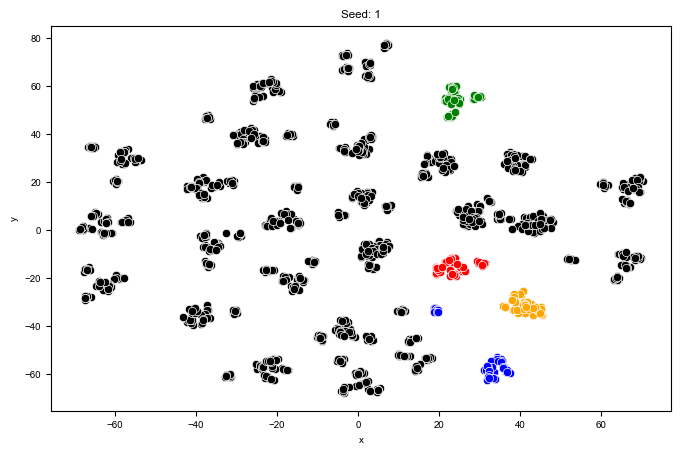

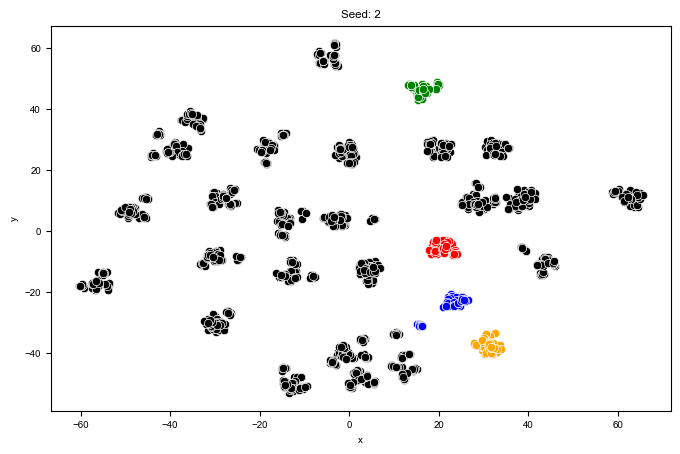

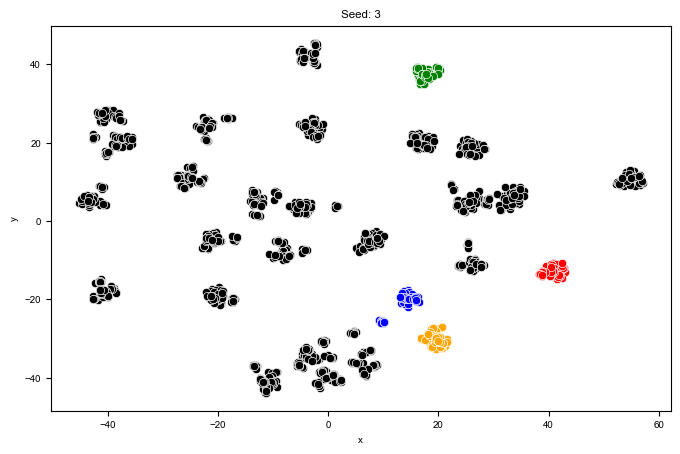

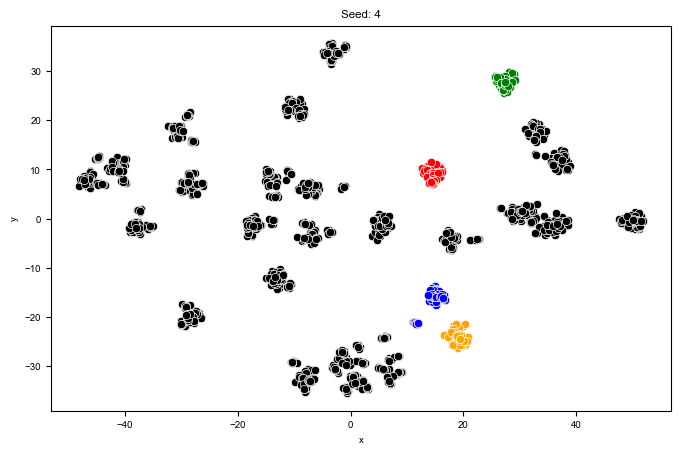

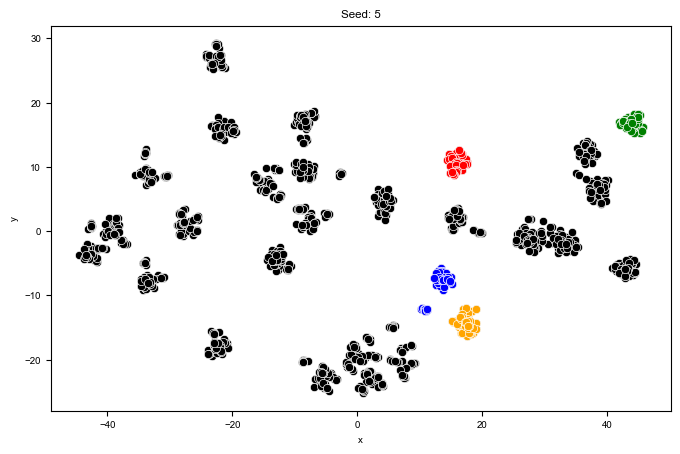

,x,y,DNA_name,model_id,seed,perp
0,17.321,28.266,AqpZ,0,1,10
1,17.571,30.079,AqpZ,1,1,10
2,17.953,28.493,AqpZ,2,1,10
3,18.877,29.117,AqpZ,3,1,10
4,17.061,30.778,AqpZ,4,1,10
...,...,...,...,...,...,...
6295,32.652,-1.626,Vol,40,5,50
6296,32.165,-1.182,Vol,41,5,50
6297,32.651,-1.964,Vol,42,5,50
6298,34.988,-2.442,Vol,43,5,50


In [33]:
all_embeddings = []
info = [
    [1,10],
    [2,20],
    [3,30],
    [4,40],
    [5,50],
]
for [seed,perp] in info:
    tsne = TSNE(random_state=seed,perplexity=perp)
    X_tsne = tsne.fit_transform(np.array(tsne_prep))
    tsne = pd.DataFrame(X_tsne,columns=['x','y'])
    tsne = tsne.join(name_model_list).rename(columns={('DNA_name', ''):'DNA_name',('model_id', ''):'model_id'})

    tsne['seed'] = seed
    tsne['perp'] = perp
    all_embeddings.append(tsne)
    fig,ax = plt.subplots(figsize=(8,5))
    sns.scatterplot(data=tsne,x='x',y='y',color='black',ax=ax)
    sns.scatterplot(data=tsne[tsne['DNA_name'] == 'Beta'],x='x',y='y',color='blue',ax=ax)
    sns.scatterplot(data=tsne[tsne['DNA_name'] == 'Dia'],x='x',y='y',color='red',ax=ax)
    sns.scatterplot(data=tsne[tsne['DNA_name'] == 'Mito'],x='x',y='y',color='orange',ax=ax)
    sns.scatterplot(data=tsne[tsne['DNA_name'] == 'CD47'],x='x',y='y',color='green',ax=ax)
    
    plt.title(f'Seed: {seed}')
    plt.show()
all_embeddings = pd.concat(all_embeddings).reset_index(drop=True)
all_embeddings
# tsne

In [35]:
meta = pd.read_excel('../all_data/General_data/protein_metadata.xlsx').fillna('-')
temp = all_embeddings[all_embeddings['perp'] == 30].copy()

temp = temp.set_index('DNA_name').join(meta[['DNA_name','Organism','Length','tm_count']].set_index('DNA_name')).reset_index()
temp


,DNA_name,x,y,model_id,seed,perp,Organism,Length,tm_count
0,AqpZ,15.880,19.542,0,3,30,E. coli,231,6
1,AqpZ,16.448,18.986,1,3,30,E. coli,231,6
2,AqpZ,16.526,19.474,2,3,30,E. coli,231,6
3,AqpZ,17.025,18.605,3,3,30,E. coli,231,6
4,AqpZ,16.029,18.701,4,3,30,E. coli,231,6
...,...,...,...,...,...,...,...,...,...
1255,Vol,32.968,5.839,40,3,30,H. sapiens,314,4
1256,Vol,32.245,5.393,41,3,30,H. sapiens,314,4
1257,Vol,33.362,5.815,42,3,30,H. sapiens,314,4
1258,Vol,34.752,8.138,43,3,30,H. sapiens,314,4


In [37]:
means = temp[['DNA_name','x','y']].groupby('DNA_name').agg('mean')
stdevs = temp[['DNA_name','x','y']].groupby('DNA_name').agg('std')
tsne_calcs = means.join(stdevs,lsuffix='_mean',rsuffix='_stdev')
tsne_calcs['stdev'] = (tsne_calcs['x_stdev'] + tsne_calcs['y_stdev']) / 2
tsne_calcs = tsne_calcs.join(meta[['DNA_name','Organism','Length','tm_count']].set_index('DNA_name')).reset_index()
tsne_calcs

,DNA_name,x_mean,y_mean,x_stdev,y_stdev,stdev,Organism,Length,tm_count
0,AqpZ,17.024,20.238,1.148,1.160,1.154,E. coli,231,6
1,Aux,-38.074,19.709,1.471,1.493,1.482,A. thaliana,472,10
2,B2AR,7.662,-5.131,1.228,1.374,1.301,H. sapiens,413,7
3,B3AR,-7.645,-7.679,1.882,1.433,1.657,H. sapiens,408,7
4,Beta,13.594,-20.894,2.132,2.624,2.378,A. thaliana,303,4
...,...,...,...,...,...,...,...,...,...
23,OR1D2,-20.456,-4.866,1.964,1.152,1.558,H. sapiens,312,7
24,OR1E1,-12.321,5.054,1.586,2.129,1.858,H. sapiens,314,7
25,OR2AG1,-11.315,-40.306,1.296,2.112,1.704,H. sapiens,316,7
26,SecYE-G,6.258,-34.817,1.509,3.625,2.567,E. coli,443,12


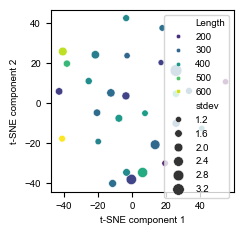

In [38]:
fig,ax = plt.subplots(figsize=[6*cm,6*cm])

sns.scatterplot(data=tsne_calcs,x='x_mean',y='y_mean',hue='Length',size='stdev',palette='viridis',s=10)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# plt.savefig(f'{fig_folder}/Fig4A-rxn_cluster_length_centroid.svg',format='svg',dpi=300)
plt.show()

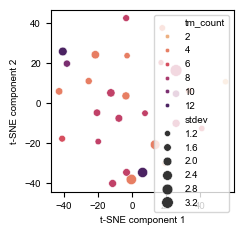

In [39]:
fig,ax = plt.subplots(figsize=[6*cm,6*cm])

sns.scatterplot(data=tsne_calcs,x='x_mean',y='y_mean',hue='tm_count',size='stdev',palette='flare',s=10)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# plt.savefig(f'{fig_folder}/rxn_cluster_tm_centroid.svg',format='svg',dpi=300)

plt.show()

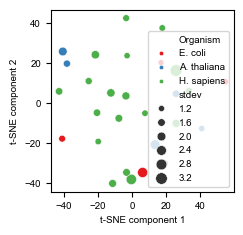

In [40]:
fig,ax = plt.subplots(figsize=[6*cm,6*cm])

sns.scatterplot(data=tsne_calcs,x='x_mean',y='y_mean',hue='Organism',size='stdev',palette='Set1',s=10)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# plt.savefig(f'{fig_folder}/Fig4A-rxn_cluster_organism_centroid.svg',format='svg',dpi=300)
plt.show()

In [91]:
tsne_calcs.set_index('DNA_name').to_excel(f'{data_folder}/Fig4A-tSNE-rxn_embedding.xlsx')

In [88]:
tsne_calcs

,DNA_name,x_mean,y_mean,x_stdev,y_stdev,stdev,Organism,Length,tm_count
0,AqpZ,22.178,26.741,1.080,1.308,1.194,E. coli,231,6
1,Aux,-37.306,20.688,1.466,1.336,1.401,A. thaliana,472,10
2,B2AR,8.626,-9.751,1.119,1.336,1.228,H. sapiens,413,7
3,B3AR,-7.748,-7.766,2.121,1.249,1.685,H. sapiens,408,7
4,Beta,18.575,-22.559,2.903,1.143,2.023,A. thaliana,303,4
...,...,...,...,...,...,...,...,...,...
23,OR1D2,-19.024,-3.704,1.855,1.492,1.674,H. sapiens,312,7
24,OR1E1,-9.484,6.275,1.624,2.287,1.956,H. sapiens,314,7
25,OR2AG1,-12.380,-41.333,1.532,1.683,1.608,H. sapiens,316,7
26,SecYE-G,6.585,-34.233,2.735,2.594,2.664,E. coli,443,12
